# Decoded Quantum Interferometry Algorithm

In [1]:
import os, sys

# if this notebook is in notebooks/, go up one level then into src/
root = os.path.abspath(os.path.join(os.getcwd(), "..", "src"))
sys.path.insert(0, root)

import numpy as np
import warnings
import pprint
pp = pprint.PrettyPrinter(depth=4)

# Qiskit imports for simulation and circuit construction
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector, partial_trace

# Custom module imports 
from dqi.initialization.state_preparation.gates import UnaryAmplitudeEncoding
from dqi.initialization.calculate_w import get_optimal_w

from dqi.dicke_state_preparation.gates import UnkGate

from dqi.decoding.gates import GJEGate
from dqi.decoding.BPQM.linearcode import LinearCode
from dqi.decoding.BPQM.decoders import create_init_qc, decode_single_syndrome
from dqi.decoding.BPQM.cloner import VarNodeCloner

from dqi.utils.graph import get_max_xorsat_matrix, find_graph_with_target_max_solutions
from dqi.utils.solver import brute_force_max
from dqi.utils.visualize import draw_graph, plot_results_union_plotly
from dqi.utils.counts import post_selection_counts, combine_counts

warnings.filterwarnings("ignore")

## Brute-Force Objective Landscape Visualization

Compute the brute-force objective values for every assignment and visualize the resulting landscape.
This plot will later be compared with the simulation data.


In [2]:
 
H = np.array([[1, 1, 0, 0, 1, 0, 0, 0], 
              [0, 1, 1, 0, 0, 1, 0, 0], 
              [0, 0, 1, 1, 0, 0, 1, 0], 
              [1, 0, 0, 1, 0, 0, 0, 1]])

B = H.T
v = np.ones(B.shape[0])
v

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [3]:
brute_force_results = brute_force_max(B, v)
plot_results_union_plotly(
    brute_force_results,
    {},
    plot_name="Objective Values Landscape",
    spline_smoothing=1.3
)


In [4]:
n = len(B[0])  # Number of qubits corresponding to constraints
m, p, r, ell = len(B), 2, 1, 2  # Additional parameters for state preparation

# Compute optimal weight values for the initialization
w = get_optimal_w(m, ell, p, r)
 
print("Optimal W_k value: ", w.tolist())

Optimal W_k value:  [0.42640143271122083, 0.7071067811865476, 0.5640760748177662, 0.0]


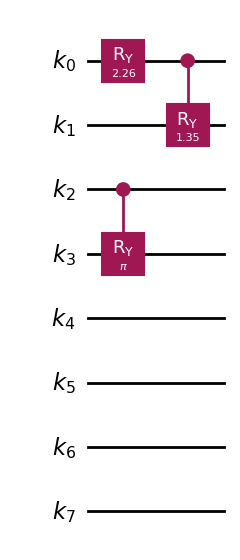

In [5]:
# Build the initialization circuit using Weighted Unary Encoding
init_qregs = QuantumRegister(m, name='k')
initialize_circuit = QuantumCircuit(init_qregs)
WUE_Gate = UnaryAmplitudeEncoding(num_bit=m, weights=w)
initialize_circuit.append(WUE_Gate, range(m))
display(initialize_circuit.decompose().draw('mpl'))
show_sv = False
if show_sv:
    display(Statevector(initialize_circuit).draw('latex'))


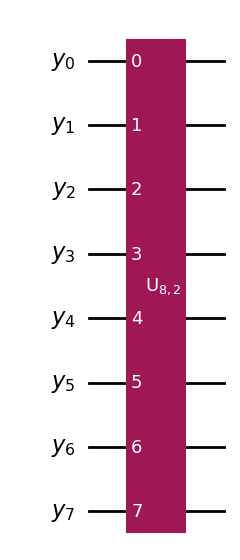

In [6]:
# Prepare the Dicke state circuit
dicke_qregs = QuantumRegister(m, name='y')
dicke_circuit = QuantumCircuit(dicke_qregs)
max_errors = int(np.nonzero(w)[0][-1]) if np.any(w) else 0
dicke_circuit.append(UnkGate(m, max_errors), range(m))
display(dicke_circuit.draw('mpl'))

In [7]:
theta = 0.2 * np.pi
cloner = VarNodeCloner(theta)
code = LinearCode(None, H)
syndrome_qc = QuantumCircuit(code.hk)

decoded_bits, decoded_qubits, qc_decode = decode_single_syndrome(
    syndrome_qc=syndrome_qc,
    code=code,
    prior=0.5,
    theta=theta,
    height=2,
    shots=1024,
    debug=True,
    run_simulation=False
)

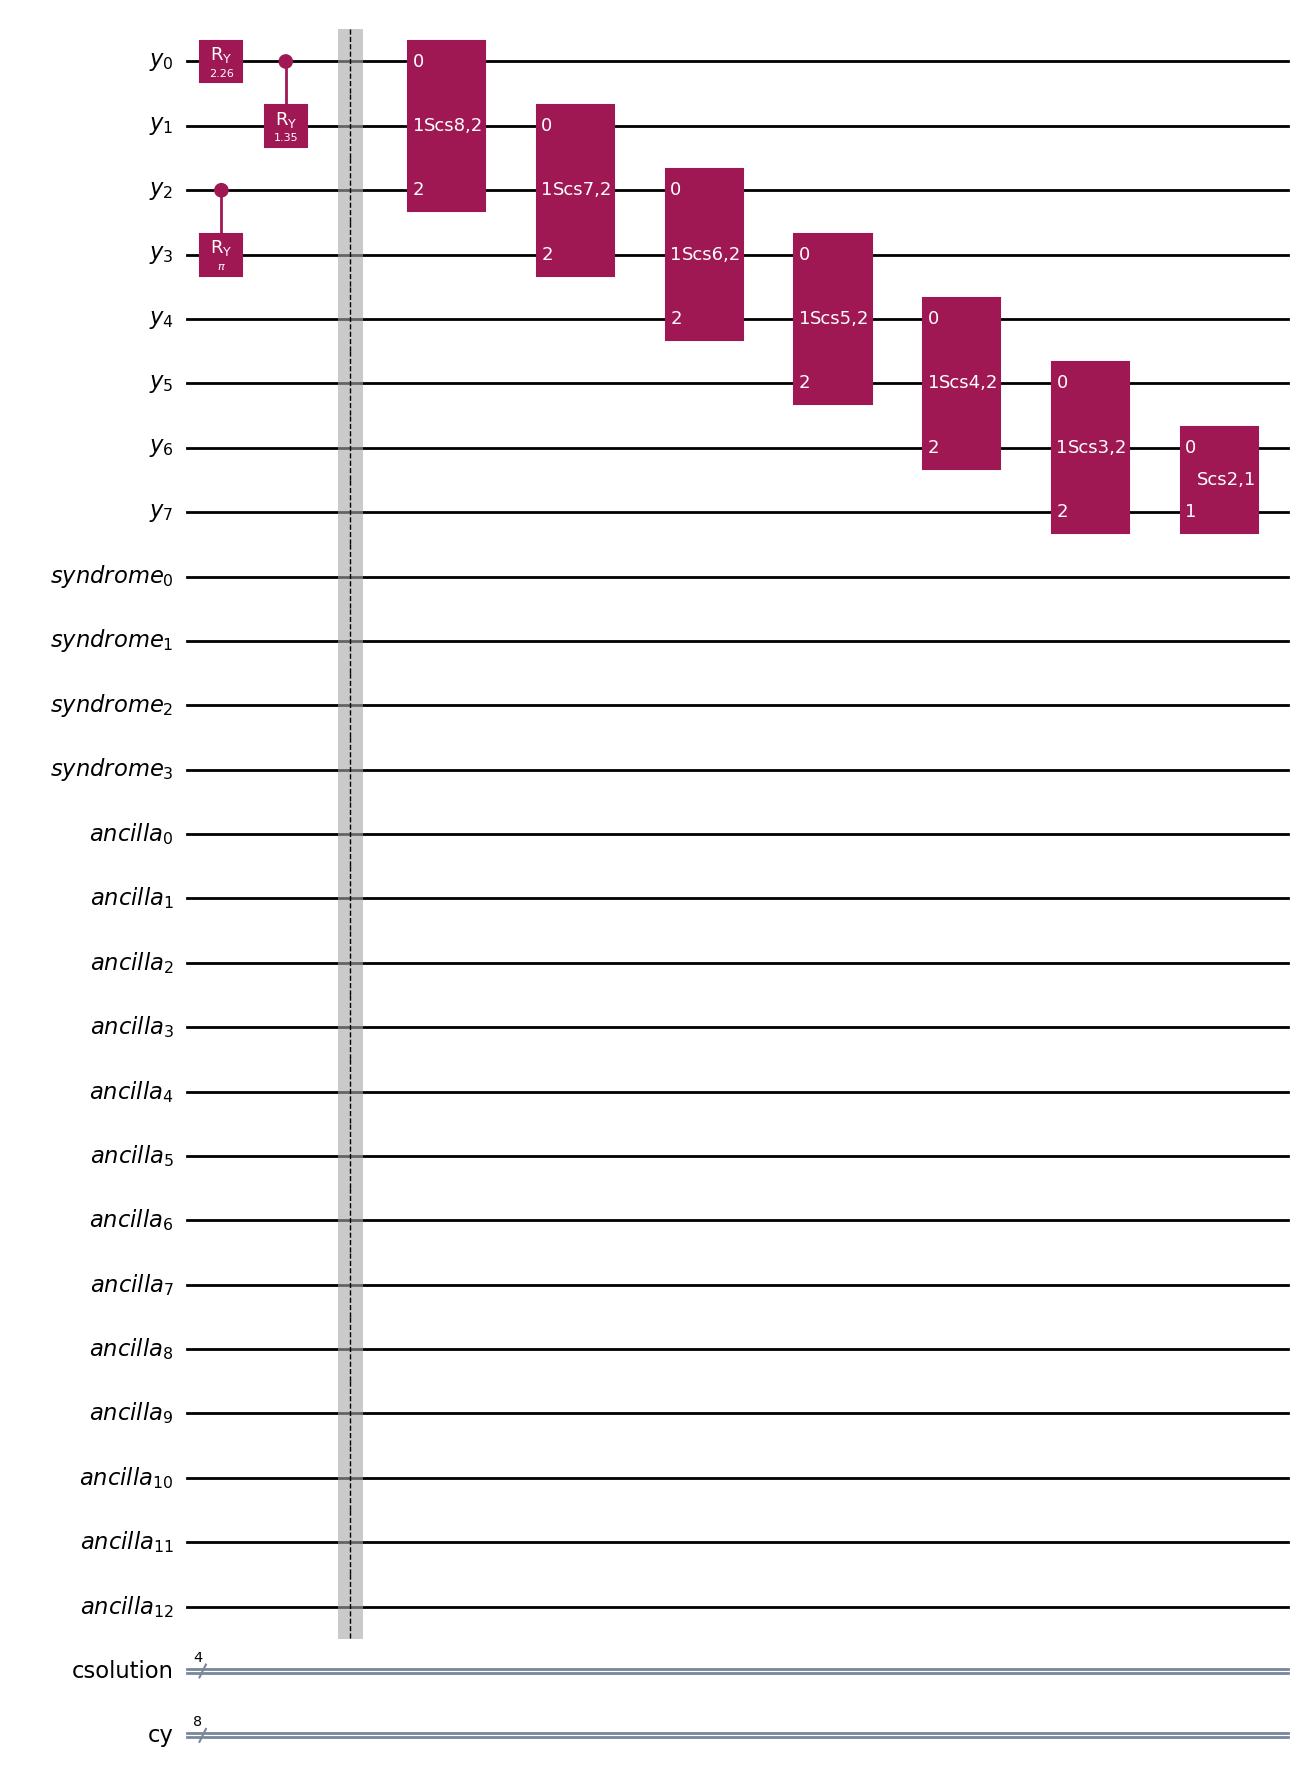

In [8]:
# Create registers for syndrome and measurement
dicke_qregs = QuantumRegister(m, name='y') 
dicke_cregs = ClassicalRegister(m, name='cy')
syndrome_qregs = QuantumRegister(n, name='syndrome')
syndrome_cregs = ClassicalRegister(syndrome_qregs.size, name='csolution')
ancilla_qregs =  QuantumRegister(qc_decode.num_qubits - m, name='ancilla')
# Build the DQI circuit by composing initialization and Dicke circuits
dqi_circuit = QuantumCircuit(dicke_qregs, syndrome_qregs, syndrome_cregs, dicke_cregs, ancilla_qregs)
dqi_circuit.compose(initialize_circuit, inplace=True)
dqi_circuit.barrier()
dqi_circuit.compose(dicke_circuit, inplace=True)
display(dqi_circuit.decompose().draw('mpl'))
if show_sv:
    display(Statevector(dqi_circuit).draw('latex'))

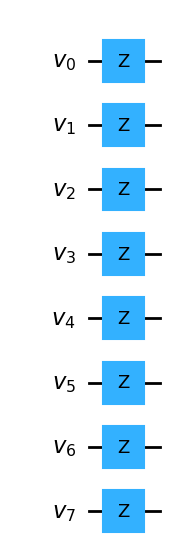

In [9]:
# Apply phase flip operations based on v
v_phase_qregs = QuantumRegister(m, name='v')
v_phase_flip_circuit = QuantumCircuit(v_phase_qregs)
for i in range(len(v)):
    if v[i] == 1:
        v_phase_flip_circuit.z(i)
display(v_phase_flip_circuit.draw('mpl'))

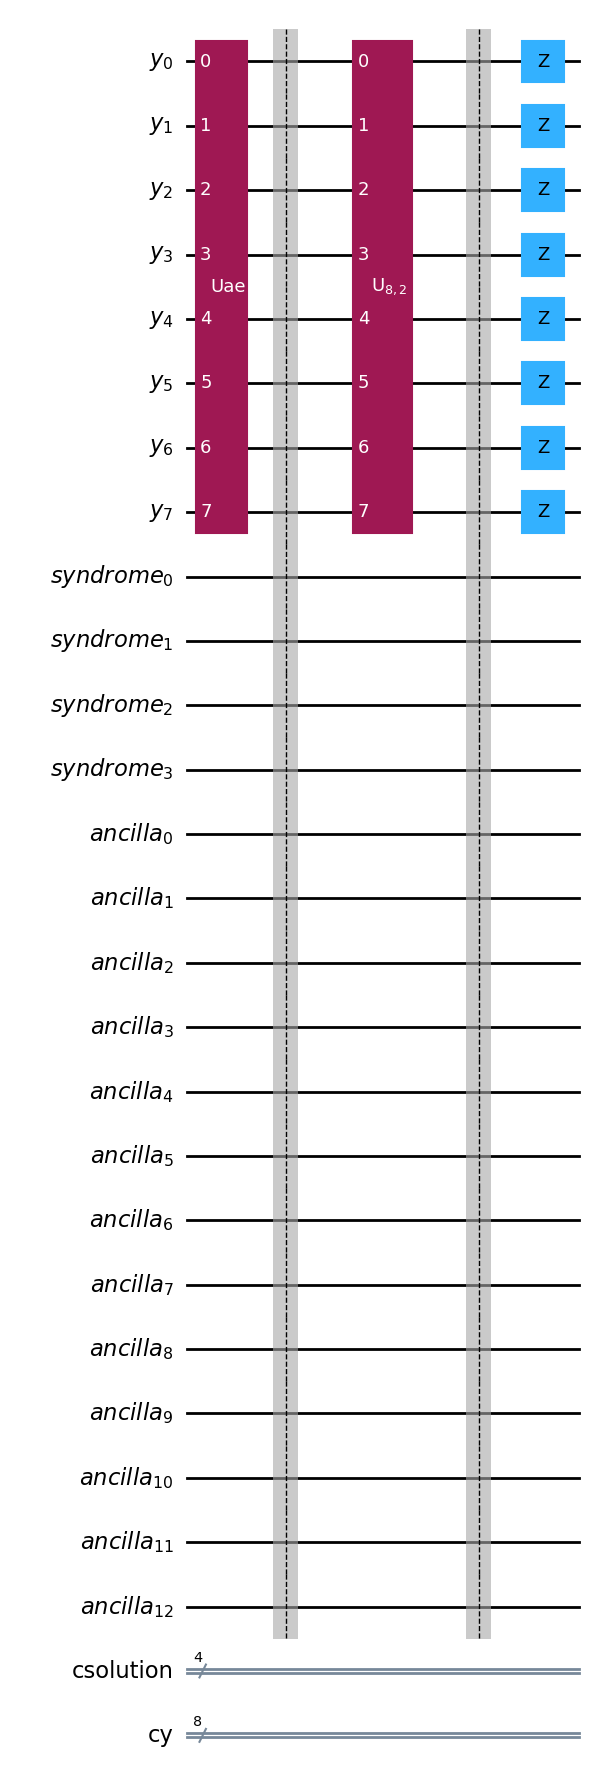

In [10]:
dqi_circuit.barrier()
dqi_circuit.compose(v_phase_flip_circuit, qubits=range(m), inplace=True)
display(dqi_circuit.draw('mpl'))

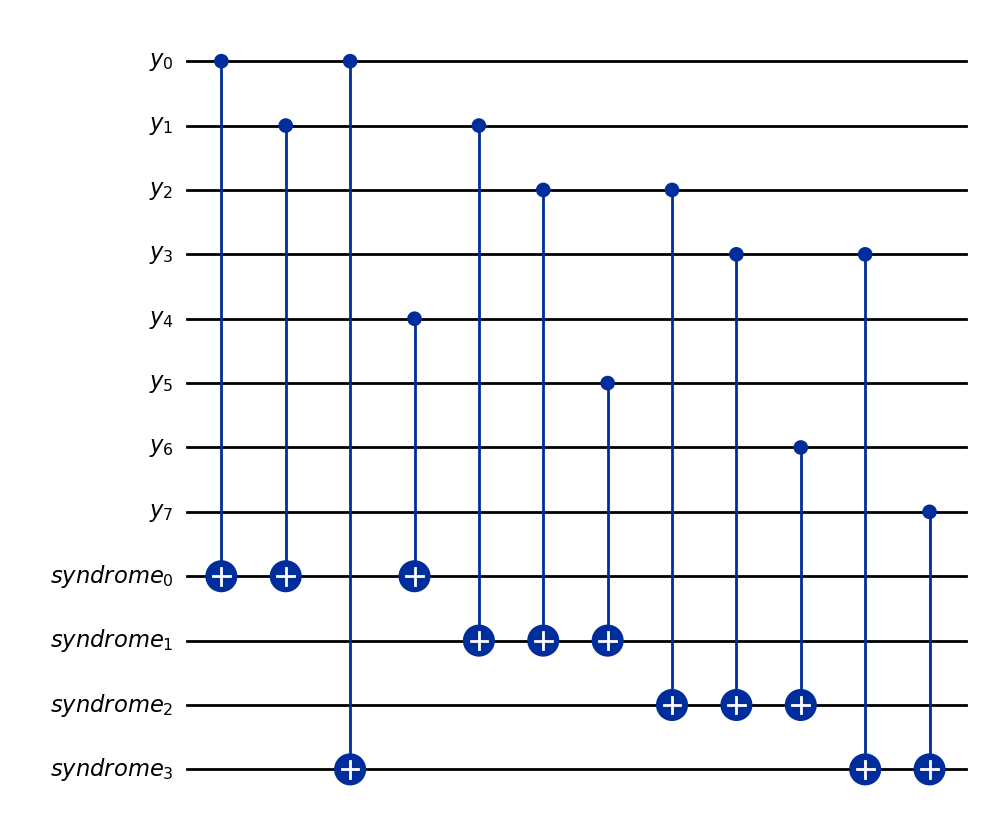

In [11]:
# Encode the constraint matrix B using CNOT gates
B_circuit = QuantumCircuit(dicke_qregs, syndrome_qregs)
for i in range(n):
    for j in range(m):
        if B.T[i][j] == 1:
            B_circuit.cx(j, m+i)
display(B_circuit.draw('mpl'))

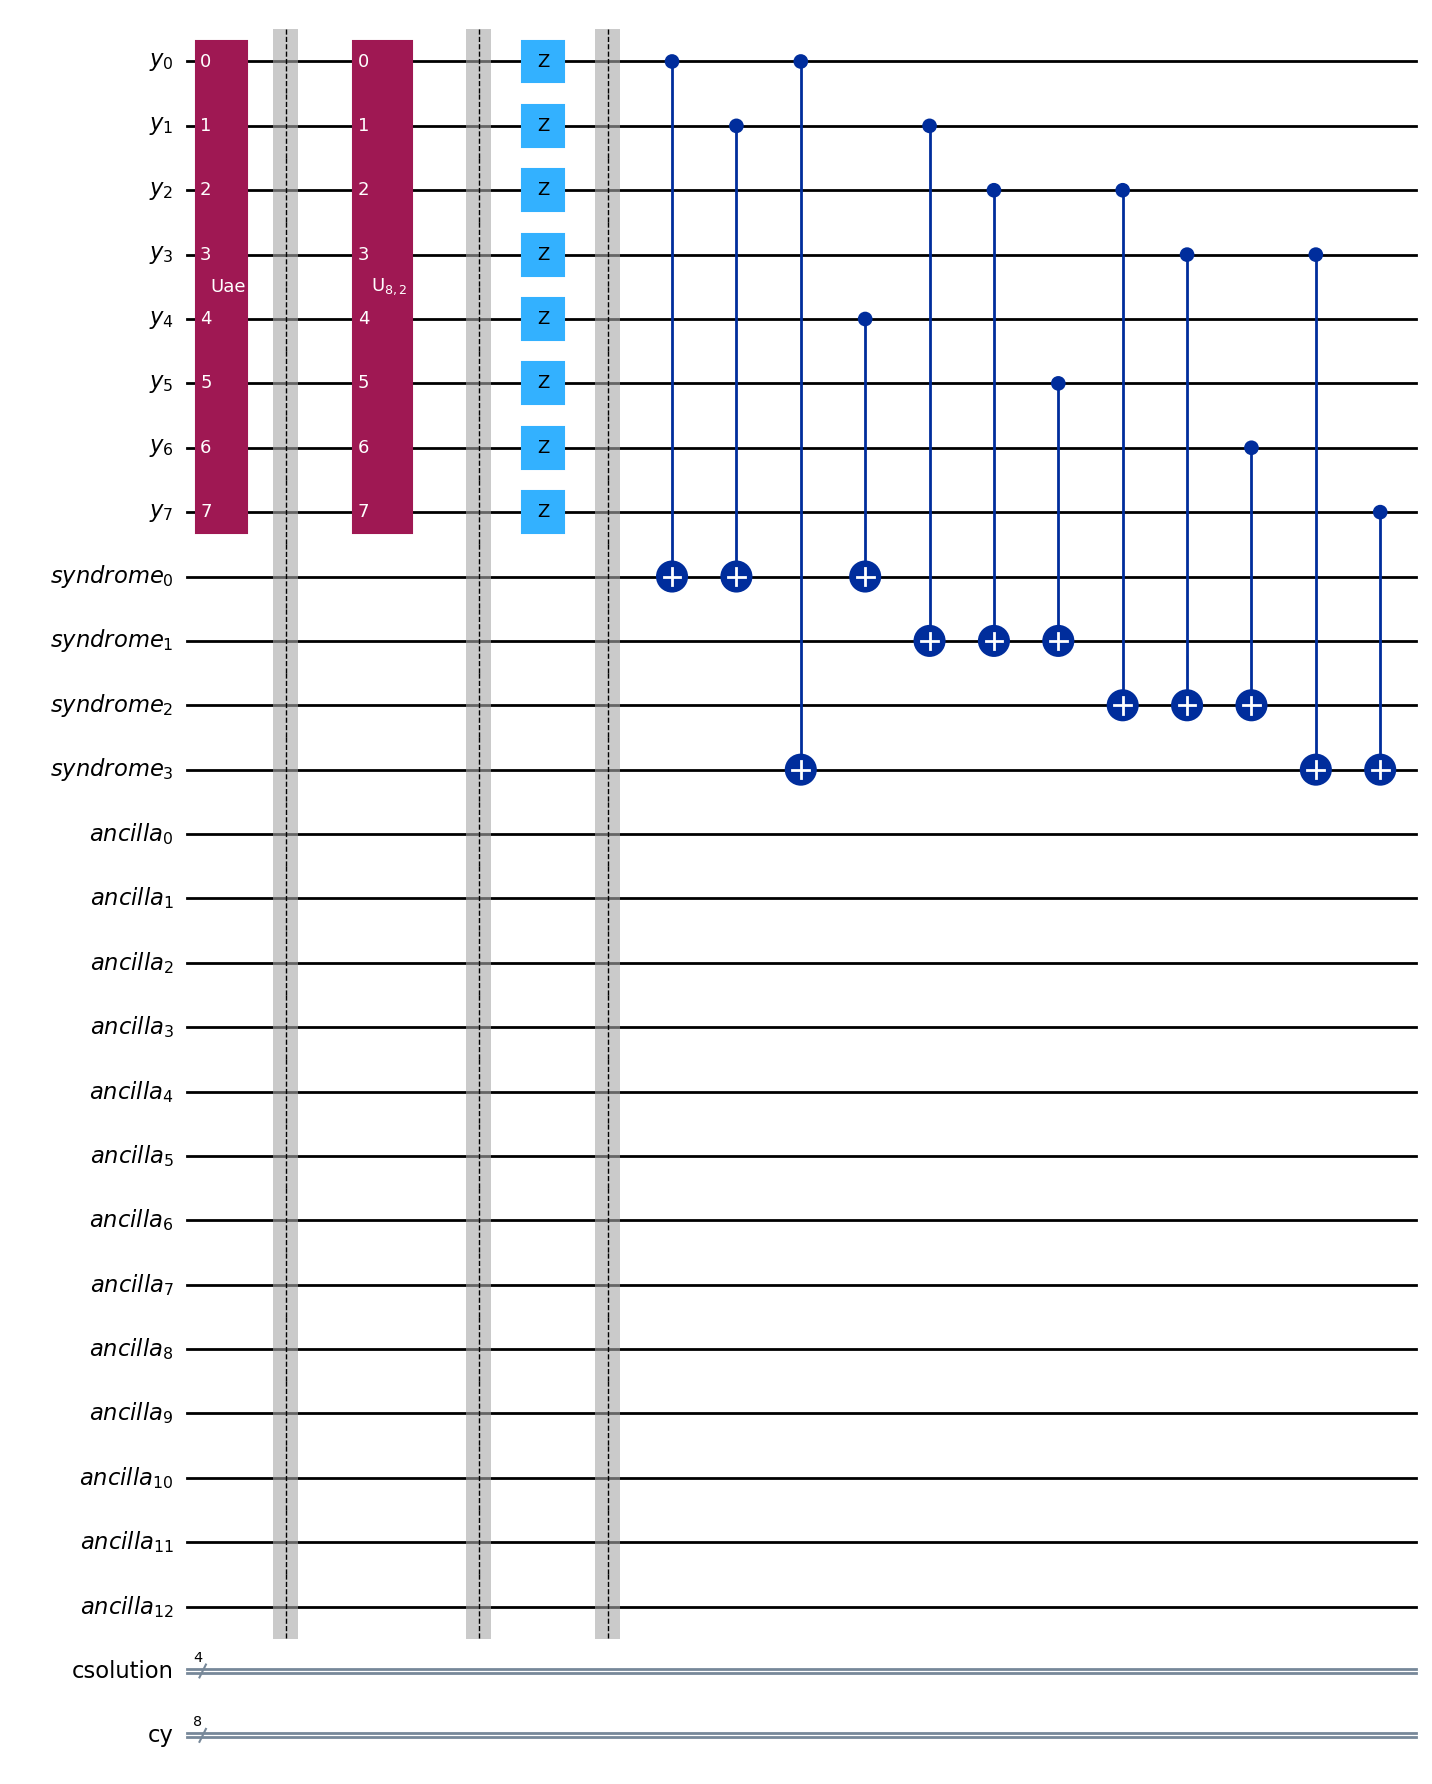

In [12]:
dqi_circuit.barrier()
dqi_circuit.compose(B_circuit, qubits=list(range(m+n)), inplace=True)
display(dqi_circuit.draw('mpl'))

# Visualize the reduced state (if desired)
if show_sv:
    reduced_density_matrix = partial_trace(Statevector(dqi_circuit), range(m))
    Statevector(np.diagonal(reduced_density_matrix)).draw('latex')



In [13]:
dqi_circuit_copy = dqi_circuit.copy()
dqi_circuit_copy.compose(qc_decode, qubits=list(range(dicke_qregs.size, qc_decode.num_qubits)) + list(range(dicke_qregs.size))
                         , inplace=True)

In [14]:
for i in range(n):
    dqi_circuit_copy.h(m+i)
    
# Measurement
dqi_circuit_copy.barrier()
dqi_circuit_copy.measure(dicke_qregs, dicke_cregs)
dqi_circuit_copy.measure(syndrome_qregs, syndrome_cregs)

In [15]:
simulator = AerSimulator()
transpiled_circuit = transpile(dqi_circuit_copy, backend=simulator)
result = simulator.run(transpiled_circuit, shots=100000).result()
counts = result.get_counts(dqi_circuit_copy)
sorted_counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}
sorted_counts

{'10010001 0101': 968,
 '01011001 0101': 949,
 '11111010 0101': 936,
 '00000000 1010': 929,
 '11110101 0101': 928,
 '10011110 0101': 925,
 '10101100 0101': 920,
 '11001000 0101': 916,
 '11000111 0101': 904,
 '01101011 0101': 903,
 '01011001 1010': 899,
 '01010110 1010': 894,
 '10011110 1010': 892,
 '01100100 0101': 892,
 '00110010 0101': 892,
 '00000000 0101': 892,
 '10010001 1010': 891,
 '00110010 1010': 888,
 '10101100 1010': 888,
 '11001000 1010': 885,
 '01010110 0101': 883,
 '11111010 1010': 879,
 '00111101 0101': 877,
 '00001111 0101': 877,
 '00111101 1010': 874,
 '11110101 1010': 873,
 '10100011 0101': 870,
 '10100011 1010': 868,
 '00001111 1010': 867,
 '01100100 1010': 855,
 '01101011 1010': 854,
 '11000111 1010': 848,
 '10010001 0111': 552,
 '11000111 1101': 541,
 '11111010 0111': 537,
 '01011001 0111': 533,
 '00111101 0111': 529,
 '00000000 0111': 521,
 '10101100 1011': 521,
 '11001000 1011': 519,
 '01100100 1101': 519,
 '01010110 0111': 518,
 '01101011 1011': 517,
 '00001111 

In [16]:
plot_results_union_plotly(
    brute_force_results,
    counts,
    plot_name="Comparison of DQI Results with True Objective Values",
    spline_smoothing=1.3
)


In [17]:
counts_filtered = post_selection_counts(counts)
plot_results_union_plotly(
    brute_force_results,
    counts_filtered,
    plot_name="Comparison of DQI Results with True Objective Values (Post-selected on |0⟩)",
    spline_smoothing=1.3
)


In [19]:
combined_counts = combine_counts(counts)
plot_results_union_plotly(
    brute_force_results,
    combined_counts,
    plot_name="Comparison of DQI Result and True Objective Values (Combined)",
    spline_smoothing=1.3
)
